---

##  Reversible Classical Computation

_course: quantum cryptography for beginners
<br>date: 30 november 2024
<br>author: burton rosenberg_

---


In [1]:
import qiskit
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator, Pauli 
from qiskit.visualization import plot_bloch_multivector, plot_bloch_vector
from IPython.display import display, Math, HTML
import time, math
from qiskit.providers.basic_provider import BasicSimulator
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter

print(f'\nqiskit version: {qiskit.version.get_version_info()}\n')

import math
import numpy as np
import matplotlib.pyplot as plt



qiskit version: 1.1.2





### Creating a Toffoli gate

The Toffoli gate is the double controlled NOT, CCNOT. It is the logical and of two inputs, with the result applied to the ancillary as an inversion or not, if the two inputs are 1 or otherwise. It is interesting to wonder if the Toffoli gate is a new form of gate, or can it be constructed from gates which have only one control. 

It can be constructed with two CNOTs and new gate, a controled square root of a CNOT, and its inverse.

Let there be a square root of the CNOT gate, $\sqrt{X_c}^2 = X_c$ where $c\in\{\,|0\rangle, |1\rangle\,\}$ is the 
control qubit. Along with its inverse construct the cascade,

$$
 \sqrt{X_a} \circ\sqrt{X_c}^{-1} \circ \sqrt{X_b}.
$$

For qubits $|x\rangle, y\rangle$ and ancillary $|z\rangle$, create the Toffoli gate,

$$
T\,|x\,y\,z\rangle = \bigl (\sqrt{X_x} \circ\sqrt{X_{x\oplus y}}^{-1} \circ \sqrt{X_y}\bigr)\, |z\rangle
$$

The sense of this construction is that of the 6 possible controls to the gates, exactly four are used. Those are either all receive a $|0\rangle$, or exactly two receive a $|1\rangle$. In those three cases, two cancel and only $|11\rangle$ completes to an inversion. Therefore,

$$
T\,|x\,y\,z\rangle = |x\,\,y\,((x\land y)\oplus z)\rangle
$$


In [2]:
qc = QuantumCircuit(2)
qc.csx(0,1)
op = Operator(qc)
display('csx',op.draw('latex'))
op2 = op.adjoint()
display('csx adjoint',op2.draw('latex'))
qc = QuantumCircuit(2)
qc.cu(np.pi/2, np.pi/2, -np.pi/2, -np.pi/4, 0, 1)
op = Operator(qc)
display('cu',op.draw('latex'))


'csx'

<IPython.core.display.Latex object>

'csx adjoint'

<IPython.core.display.Latex object>

'cu'

<IPython.core.display.Latex object>

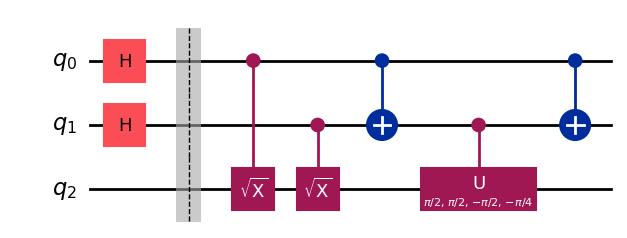

<IPython.core.display.Latex object>

In [3]:
def toffoli(qc):

    # 
    qc_a = QuantumCircuit(2)
    qc_a.csx(0,1)
    op = Operator(qc_a).adjoint()

    qc.csx(0,2)
    qc.csx(1,2)
    qc.cx(0,1)
    qc.cu(np.pi/2, np.pi/2, -np.pi/2, -np.pi/4, 1, 2)
    #qc.append(op,[1,2])
    qc.cx(0,1)
    return qc

qc = QuantumCircuit(3)
qc.h(0)
qc.h(1)
qc.barrier()
qc = toffoli(qc)
display(qc.draw('mpl'))
display(Statevector(qc).draw('latex'))

### Kitaev's Construction

See _Classical and Quantum Computation_, Kitaev, Shen and Vyalyi, page 67.

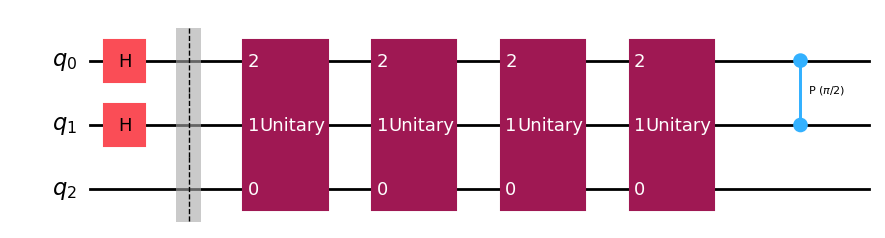

<IPython.core.display.Latex object>

In [48]:
zero = Operator([[1,0],[0,0]])
one = Operator([[0,0],[0,1]])
identity = Operator([[1,0],[0,1]])

x = (-1j/np.sqrt(2))*(Operator(Pauli('Z')) + Operator(Pauli('Y')))
x_adj = x.adjoint()
y = 1j*Operator(Pauli('Y'))
y_adj = y.adjoint()

def draw_1():
    display(x.draw('latex'))
    display(x_adj.draw('latex'))
    display(y.draw('latex'))
    display(y_adj.draw('latex'))

# draw_1()

g1 = zero.tensor(identity).tensor(identity) + one.tensor(identity).tensor(y_adj)
g2 = identity.tensor(zero).tensor(identity) + identity.tensor(one).tensor(x_adj)
g3 = zero.tensor(identity).tensor(identity) + one.tensor(identity).tensor(y)
g4 = identity.tensor(zero).tensor(identity) + identity.tensor(one).tensor(x)

qc = QuantumCircuit(3)
qc.h(0)
qc.h(1)
qc.barrier()
qubits= [2,1,0]
qc.append(g1,qargs=qubits)
qc.append(g2,qargs=qubits)
qc.append(g3,qargs=qubits)
qc.append(g4,qargs=qubits)
qc.cp(np.pi/2.0,0,1)
display(qc.draw('mpl'))
sv = Statevector(qc)
sv.draw('latex')




### Reversible classical computing

The question is, is there an analog construction in classic logic gates, for reversible computing. 

Classical bits are essentially non-reversible. Functions such as $x\land y=z$ cannot be solved for $x$ given $y$ and $z$, in general. Data is lost. Computation can be divided into reversable computing an erasure. Erasure seems to be in integrable part or computing, as data locations are overwritten, and by this familiarity, not very remarkable.

But it is remarkable because thermodynamically, computation is free. What costs energy is erasure. Fredkin and Toffoli got there gates named after them because they were investigating reversible classical computation. They arrived at a billard ball computer using their gates that, in the ideal situation of completely elastic collissions, computed with out energy loss. 

On the other hand, to erase information requires the Landauer Energy of $k_B\,T\ln 2$ per bit, where
$k_B$ is the Boltzmann constant.

The xor gate is a classical, reversible gate, the analog of the CNOT. Is it possible to build a Toffoli from xors? No. It is not possible. Toffoli and Fredkin had to propose the gate. However, it is possible to build an xor from a Toffoli, as well as every other logical gate. The Toffoli gate is the universal gate for reversible classical computation.


### Additional Constructions

A double controlled $H$ gate can be done the same as the above constrution. Also, using the construction with three inputs, with three square root and an inverse square root controled by the parity of the three bits, gives a X controled by the majority.


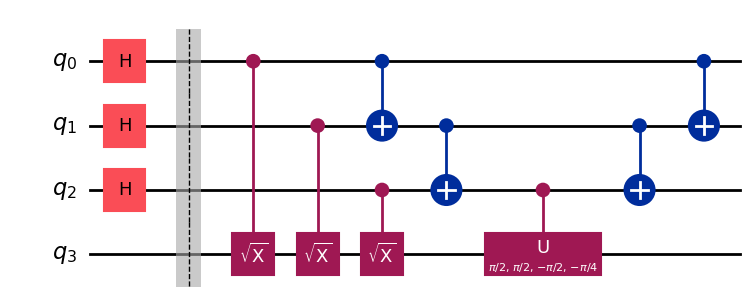

<IPython.core.display.Latex object>

In [5]:
def majority_X(qc):

    qc.csx(0,3)
    qc.csx(1,3)
    qc.csx(2,3)
    qc.cx(0,1)
    qc.cx(1,2)
    qc.cu(np.pi/2, np.pi/2, -np.pi/2, -np.pi/4, 2, 3)
    qc.cx(1,2)
    qc.cx(0,1)
    return qc

qc = QuantumCircuit(4)
for i in range(3):
    qc.h(i)
qc.barrier()
qc = majority_X(qc)
display(qc.draw('mpl'))
display(Statevector(qc).draw('latex'))

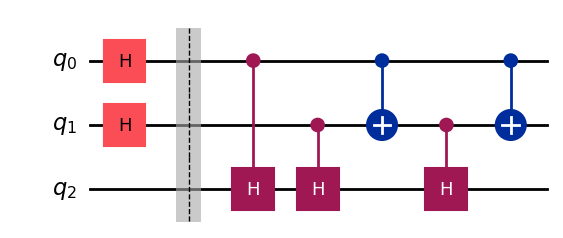

<IPython.core.display.Latex object>

In [6]:
# not sure why i thought this would be a CCH .. but it obviously isn't

def cc_h(qc):
    qc.ch(0,2)
    qc.ch(1,2)
    qc.cx(0,1)
    qc.ch(1,2)
    qc.cx(0,1)
    return qc

qc = QuantumCircuit(3)
for i in range(2):
    qc.h(i)
qc.barrier()
qc = cc_h(qc)
display(qc.draw('mpl'))
display(Statevector(qc).draw('latex'))